In [1]:
from datasets import load_dataset
from torchvision import transforms
import torch
from torch.nn import functional as F

from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel

from tqdm import tqdm
from matplotlib import pyplot as plt
from genaibook.core import show_images

/home/ubuntu/Projects/Diffusion/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
torch.tensor([100, 200]).view(-1, 1).shape

torch.Size([2, 1])

In [38]:
import math
class SinusoidalPositionEmbeddings(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


s = SinusoidalPositionEmbeddings(10)
s(torch.tensor([100, 200]).view(-1, 1)).squeeze().shape

torch.Size([2, 10])

In [57]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

Repo card metadata block was not found. Setting CardData to empty.


In [86]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
from PIL import Image

In [43]:
# dataset[0]['images'].permute(1, 2, 0)

In [47]:
# show_images??

In [63]:
image_size = 64

preprocess = transforms.Compose(
    [ transforms.Resize((image_size, image_size)),  # Resize
      transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
      transforms.ToTensor(),  # Convert to tensor (0, 1)
      transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

In [64]:
def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}

dataset.set_transform(transform)
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

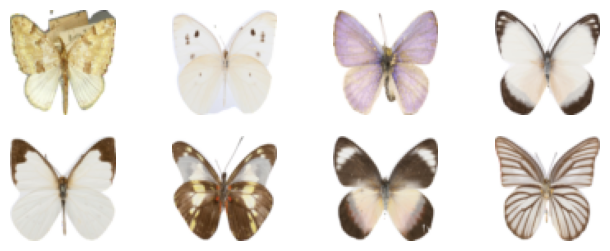

In [5]:
batch = next(iter(train_dataloader))

# When we normalized, we mapped (0, 1) to (-1, 1)
# Now we map back to (0, 1) for disp lay
show_images(batch["images"][:8] * 0.5 + 0.5, figsize=(8, 3))

### Adding Noise

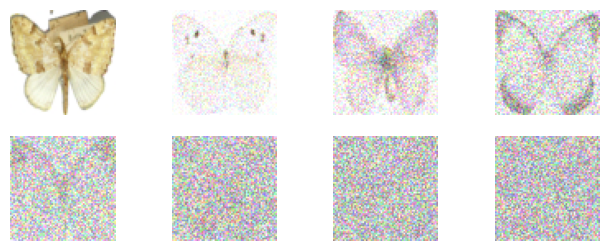

In [83]:
# We'll learn about beta_start and beta_end in the next sections
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)

# Create a tensor with 8 evenly spaced values from 0 to 999
timesteps = torch.linspace(0, 999, 8).long()

# We load 8 images from the dataset and
# add increasing amounts of noise to them
x = batch["images"][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1), figsize=(8, 3))

### U-Net

In [93]:
model = UNet2DModel(
    in_channels=3,  # 3 channels for RGB images
    sample_size=64,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

# Pass a batch of data through to make sure it works
with torch.inference_mode():
    out = model(noised_x.to(device), timestep=timesteps.to(device)).sample

# Input and output are the same size
print(noised_x.shape)
print(out.shape)

torch.Size([8, 3, 64, 64])
torch.Size([8, 3, 64, 64])


### Training

In [97]:
num_epochs = 50  # How many runs through the data should we do?
lr = 1e-4  # What learning rate should we use
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []  # Somewhere to store the loss values for later plotting

# Train the model (this takes a while)
for epoch in range(num_epochs):
    print("Epoch", epoch)
    
    for batch in train_dataloader:
        # Load the input images
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(device)

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=device,
        ).long()

        # Add noise to the clean images according
        # to the noise magnitude at each timestep
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        # The model also uses the timestep as an input
        # for additional conditioning
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise
        loss = F.mse_loss(noise_pred, noise)

        # Store the loss for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49


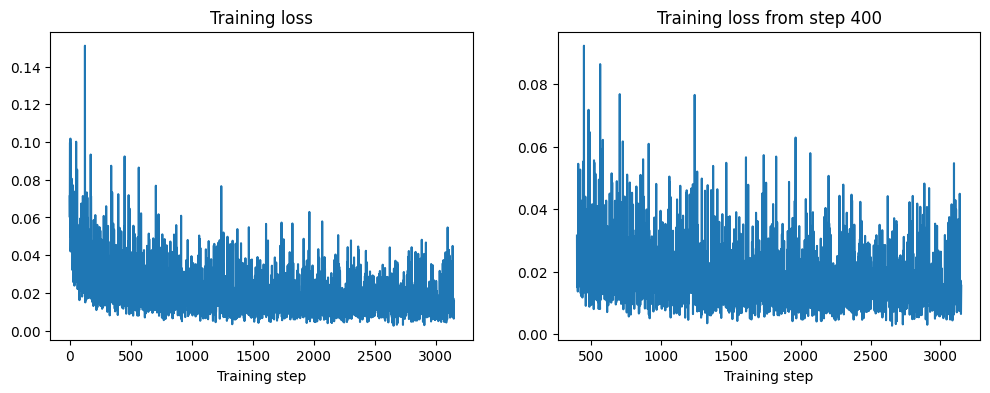

In [100]:
plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step")

plt.subplot(1, 2, 2)
plt.plot(range(400, len(losses)), losses[400:])
plt.title("Training loss from step 400")
plt.xlabel("Training step");

### Sampling

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.77it/s]


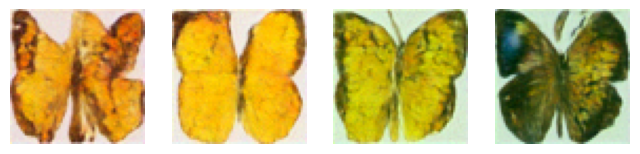

In [107]:
pipeline = DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=4).images
show_images(ims, nrows=1, figsize=(8, 3))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.77it/s]


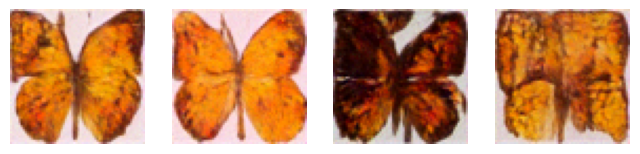

In [117]:
# Version without pipeline
sample = torch.randn(4, 3, 64, 64).to(device)

for t in tqdm(scheduler.timesteps):
    # Get the model prediction
    with torch.inference_mode():
        noise_pred = model(sample, t)["sample"]

    # Update sample with step
    sample = scheduler.step(noise_pred, t, sample).prev_sample

show_images(sample.clip(-1, 1) * 0.5 + 0.5, nrows=1, figsize=(8, 3))

In [129]:
scheduler.step(noise_pred, t, sample).prev_sample

Object `prev_sample` not found.
